In [1]:
from numpy import *
import numpy as np
from matplotlib import *
from scipy import *
from pylab import figure, show, setp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import find_peaks
 


In [2]:
import numba

In [3]:
#Функция ТС из вопроса
@numba.njit
def num_rossler(x1_n, y1_n, z1_n, x2_n, y2_n, z2_n, h, a, b, c, k):
    x1_n1=x1_n+h*(-y1_n-z1_n+k*(x2_n-x1_n)) # dx/dt = - y1 - z1 + k (x2 - x1 )
    y1_n1=y1_n+h*(x1_n+a*y1_n)
    z1_n1=z1_n+h*(b+z1_n*(x1_n-c))   
 
    x2_n1=x2_n+h*(-y2_n-z2_n+k*(x1_n-x2_n))
    y2_n1=y2_n+h*(x2_n+a*y2_n)
    z2_n1=z2_n+h*(b+z2_n*(x2_n-c))
 
    return x1_n1, y1_n1, z1_n1, x2_n1, y2_n1, z2_n1

# Генератор производит решения динамической системы
# niter Определяет сколько точек построить
# x1, y1, z1, x2,y2,z2 - начальное положение
@numba.njit
def gen_rossler(x1, y1, z1, x2,y2,z2, dt, a,b,c,k, niter):
    yield (x1,y1,z1, x2,y2,z2)
    for _ in range(niter):
        dx1 = dt*(-y1-z1 + k*(x2-x1))
        dy1 = dt*(x1 + a*y1)
        dz1 = dt*(b + z1*(x1 - c))
    
        dx2 = dt*(-y2-z2 + k*(x1-x2))
        dy2 = dt*(x2 + a*y2)
        dz2 = dt*(b + z2*(x2 - c))
    
        x1,y1,z1 = x1+dx1, y1+dy1, z1+dz1
        x2,y2,z2 = x2+dx2, y2+dy2, z2+dz2
        
        yield (x1,y1,z1, x2,y2,z2)

In [4]:
#Now we prepare some variables
#First the parameters
a=0.165
b=0.2
c=10
K=0.1
 
#Them the time interval and the step size
t_ini=0
t_fin=32*pi
h=0.0001
numsteps=int((t_fin-t_ini)/h)
 
#using this parameters we build the time.
t=numpy.linspace(t_ini,t_fin,numsteps)
#And the vectors for the solutions
x1=numpy.zeros(numsteps)
y1=numpy.zeros(numsteps)
z1=numpy.zeros(numsteps)
 
x2=numpy.zeros(numsteps)
y2=numpy.zeros(numsteps)
z2=numpy.zeros(numsteps)
 
print(x1.size)

#We set the initial conditions
x1_0 = 0.001
y1_0 = 0.001
z1_0 = 0.001
x2_0 = 0.002
y2_0 = 0.002
z2_0 = 0.002

x1[0]=0.001
y1[0]=0.001
z1[0]=0.001
 
x2[0]=0.002
y2[0]=0.002
z2[0]=0.002
 
#This is the main loop where we use the recursive system to obtain the solution
n=x1.size-1


1005309


Считаем по-простому

In [6]:
%%timeit -n1 -r1
for k in range(0, n):
    #We use the previous point to generate the new point using the recursion
    [x1[k+1],y1[k+1],z1[k+1],x2[k+1],y2[k+1],z2[k+1]]=num_rossler(x1[k],y1[k],z1[k],x2[k],y2[k],z2[k],t[k+1]-t[k],a,b,c,K)



2.74 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Считаем с генератором

In [7]:
XYZ = np.zeros((numsteps+1, 6), dtype=float)

In [11]:
%%timeit -n1 -r1
for _xyz, xyz in zip(XYZ, gen_rossler(x1_0, y1_0, z1_0, x2_0, y2_0, z2_0,t[1]-t[0],a,b,c,K, numsteps)):
    _xyz = xyz

218 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Считаем с генератором, но в цикле

In [12]:
%%timeit -n 1 -r 1
for i, (_x1,_y1,_z1,_x2,_y2,_z2) in zip(range(numsteps), gen_rossler(x1[0],y1[0],z1[0],x2[0],y2[0],z2[0],t[1]-t[0],a,b,c,K, numsteps)):
    #We use the previous point to generate the new point using the recursion
    x1[i],y1[i],z1[i],x2[i],y2[i],z2[i]=_x1,_y1,_z1,_x2,_y2,_z2
 

567 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Ускорение счёта

`numba` очень хорошо оптимизирует вычисления, которые не задействуют объекты `Python`. Компилятор умеет эффективно работать с массивами `numpy` и взаимодействует с ними на уровне C-API.

Поэтому для максимального ускорения вычислений достаточно оптимизировать основной цикл построения решения.

In [13]:
# Вычисляет приращение переменных на очередной итерации
@numba.njit(inline='always')
def step_rossler(x1,y1,z1,x2,y2,z2, dt, a, b, c, k):
    dx1 = dt*(-y1-z1 + k*(x2-x1))
    dy1 = dt*(x1 + a*y1)
    dz1 = dt*(b + z1*(x1 - c))

    dx2 = dt*(-y2-z2 + k*(x1-x2))
    dy2 = dt*(x2 + a*y2)
    dz2 = dt*(b + z2*(x2 - c))
    
    x1,y1,z1 = x1+dx1, y1+dy1, z1+dz1
    x2,y2,z2 = x2+dx2, y2+dy2, z2+dz2
    
    return (x1,y1,z1, x2,y2,z2)


In [14]:
# Вычисляет орбиту начальной точки. Число шагов numsteps
# Возвращает набор шестимерных точек.
@numba.njit
def orbit_rossler(x1,y1,z1,x2,y2,z2, dt, a, b, c, k, numsteps):
    XYZ = np.zeros((numsteps+1)*6)
    XYZ = np.reshape(XYZ, (numsteps+1, 6))
    XYZ[0,:] = x1,y1,z1,x2,y2,z2
    for i in range(1, numsteps+1):
        x1,y1,z1,x2,y2,z2 = step_rossler(x1,y1,z1,x2,y2,z2, dt, a,b,c,k)

        XYZ[i,:] = x1,y1,z1,x2,y2,z2
    return XYZ

In [16]:
%%timeit -n7 -r10
XYZ = orbit_rossler(x1_0, y1_0, z1_0, x2_0, y2_0, z2_0,t[1]-t[0],a,b,c,K, numsteps)


67.5 ms ± 5.57 ms per loop (mean ± std. dev. of 10 runs, 7 loops each)


нужно пересчитать орбиту, так как вычисления в инструкции `%%timeit` не сохраняются в глобальном пространстве имён

In [17]:
XYZ = orbit_rossler(x1_0, y1_0, z1_0, x2_0, y2_0, z2_0,t[1]-t[0],a,b,c,K, numsteps)

Разбираем шестёрки на отдельные точки

In [18]:
x1,y1,z1,x2,y2,z2 = [ XYZ[:,i] for i in range(6) ]
x1

array([ 1.00000000e-03,  9.99810000e-04,  9.99618086e-04, ...,
       -2.38692077e+00, -2.38703969e+00, -2.38715859e+00])

Графики решения

Text(0.5, 0, 'z1(t)')

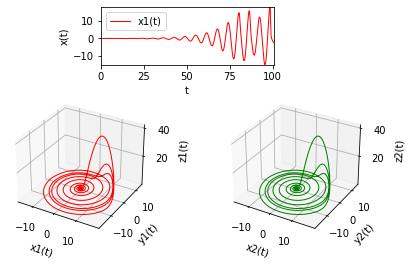

In [24]:
#Now that we have the solution in vectors t,x,y,z is time to plot them.

#We create a figure and 4 axes on it. 3 of the axes are going to be 2D and the fourth one is a 3D plot.
fig = figure()
ax1 = fig.add_axes([0.30, 0.7, 0.4, 0.2])
ax3 = fig.add_axes([0.05, 0.1, 0.4, 0.5],projection='3d')
ax4 = fig.add_axes([0.55, 0.1, 0.4, 0.5],projection='3d')
 
 
#And we add vectors to each plot
ax1.plot(t, x1[:-1],color='red',lw=1,label='x1(t)')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.legend()
ax1.axis((t_ini,t_fin,min(x1),max(x1)))
 
 
# ax1.plot(t, x2,color='green',lw=1,label='x2(t)')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.legend()
ax1.axis((t_ini,t_fin,min(x2),max(x2)))
 
ax4.plot(x2, y2,z2,color='green',lw=1)
ax4.set_xlabel('x2(t)')
ax4.set_ylabel('y2(t)')
ax4.set_zlabel('z2(t)')
 
ax3.plot(x1, y1,z1,color='red',lw=1)
ax3.set_xlabel('x1(t)')
ax3.set_ylabel('y1(t)')
ax3.set_zlabel('z1(t)')
 


## Метод Рунге-Кутта

Выше динамическая система решалась методом Эйлера. Благодаря тому, что `numba` значительно увеличивает скорость счёта, можно искать решение явным методом Рунге-Кутта.

In [19]:
# Уравнение динамической системы
@numba.njit(inline='always')
def fn_rossler(xyz, a, b, c, K):
    x1,y1,z1,x2,y2,z2 = xyz
    return np.array(( \
        (-y1-z1 + K*(x2-x1)), \
        (x1 + a*y1), \
        (b + z1*(x1 - c)), \
        (-y2-z2 + K*(x1-x2)), \
        (x2 + a*y2), \
        (b + z2*(x2 - c))\
    ))

# Шаг вычислений в методе Рунге-Кутта
@numba.njit(inline='always')
def step_rossler_rk(dt, xyz, a, b, c, K):
    y1 = fn_rossler(xyz,           a,b,c,K)
    y2 = fn_rossler(xyz+(dt/2)*y1, a,b,c,K)
    y3 = fn_rossler(xyz+(dt/2)*y2, a,b,c,K)
    y4 = fn_rossler(xyz+dt*y3,     a,b,c,K)
    
    return xyz + (dt/6)*(y1 + 2*y2 + 2*y3 + y4)

# Построение решения методом Рунге-Кутта
@numba.njit
def orbit_rossler_rk(xyz_0, dt, a, b, c, k, numsteps):
    XYZ = np.zeros((numsteps+1)*6)
    XYZ = np.reshape(XYZ, (numsteps+1, 6))
    XYZ[0] = np.array(xyz_0)
    xyz = np.array(xyz_0)
    for i in range(1, numsteps+1):
        xyz = step_rossler_rk(dt, xyz, a,b,c,k)

        XYZ[i] = xyz
    return XYZ

In [20]:
%%timeit -n3 -r 7
XYZ = orbit_rossler_rk((x1_0, y1_0, z1_0, x2_0, y2_0, z2_0),t[1]-t[0],a,b,c,K, numsteps)

692 ms ± 246 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [21]:
XYZ

array([[ 1.00000000e-03,  1.00000000e-03,  1.00000000e-03,
         2.00000000e-03,  2.00000000e-03,  2.00000000e-03],
       [ 9.99810000e-04,  1.00011650e-03,  1.01900013e-03,
         1.99959000e-03,  2.00023300e-03,  2.01800043e-03],
       [ 9.99618086e-04,  1.00023298e-03,  1.03798126e-03,
         1.99917818e-03,  2.00046596e-03,  2.03598286e-03],
       ...,
       [-2.38692077e+00,  1.17293583e+00,  1.62943730e-02,
        -2.38696966e+00,  1.17297975e+00,  1.62943117e-02],
       [-2.38703969e+00,  1.17271649e+00,  1.62941893e-02,
        -2.38708859e+00,  1.17276040e+00,  1.62941280e-02],
       [-2.38715859e+00,  1.17249713e+00,  1.62940056e-02,
        -2.38720749e+00,  1.17254104e+00,  1.62939443e-02]])